In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from matplotlib import dates as mlp_dates
import seaborn as sns

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [35]:
%matplotlib inline

In [36]:
first_data = pd.read_csv('water_data.csv')
first_data['Rainfall'] = pd.to_numeric(first_data['Rainfall'], errors='coerce')

# Split data into training and testing set
train_size = int(len(first_data) * 0.8)
train_data = first_data.iloc[:train_size]
test_data = first_data.iloc[train_size:]
#  MEAN FOR MISSING DATA
water_mean = train_data['Water Level'].mean()
drawdown_mean = train_data['Drawdown'].mean()

data = first_data.fillna(value={'Water Level': water_mean, 'Rainfall': 0, 'Drawdown': drawdown_mean}).copy()
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
data.set_index('Date', inplace=True)


In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [38]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 30
X_train, y_train = create_sequences(scaled_data[:train_size], seq_length)
X_test, y_test = create_sequences(scaled_data[train_size:], seq_length)

In [39]:
input_shape = X_train.shape[1:]
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
adam = Adam(learning_rate=0.001)
model.compile( loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [40]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.6932 - mae: 0.8286
Test Loss: 0.7449417114257812
Test Accuracy: 0.8595345616340637


In [41]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='model_weights.weights.h5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

CPU times: total: 0 ns
Wall time: 952 µs


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, batch_size=128, verbose=1)
#history = model.fit(X_train, y_train, epochs=8, validation_split=0.2, batch_size=256, verbose=1)

Epoch 1/30
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1865
Epoch 1: val_loss improved from inf to 0.00704, saving model to model_weights.weights.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 58s 173ms/step - loss: 0.1806 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 2/30
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0100
Epoch 2: val_loss improved from 0.00704 to 0.00226, saving model to model_weights.weights.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 0.0099 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0066
Epoch 3: val_loss improved from 0.00226 to 0.00200, saving model to model_weights.weights.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0065 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 4/30
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0061
Epoch 4: val_loss improved from 0.00200 to 0.00185, saving model to model_weights.weights.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.0061 - val_loss: 

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# PREDICTION
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
# SCALING FOR PREDICTION
train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, X_train[:, -1, 1:]), axis=1))[:, 0]
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, X_test[:, -1, 1:]), axis=1))[:, 0]

# SCALING FOR ACTUAL
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.show()


In [ ]:
test_data.shape, test_predictions.shape

In [ ]:
test_predictions = np.array(test_predictions)
y_test_inv = np.array(y_test_inv)

In [17]:
# sMAPE of actual data to forecasted data
fore_smape = np.mean((np.abs(test_predictions - y_test_inv) / np.abs(test_predictions + y_test_inv)/2)) * 100
fore_smape 

0.04955587025892155

In [18]:
model.save("Model_water.h5")

In [19]:
train_dates = list(data.index)

In [20]:
n_past = 15
n_days_for_prediction= 480

In [21]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='d').tolist()

In [22]:
prediction = model.predict(X_test[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [23]:
prediction_copies = np.repeat(prediction, data.shape[1], axis=-1)

In [24]:
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]

In [25]:
len(prediction_copies)

480

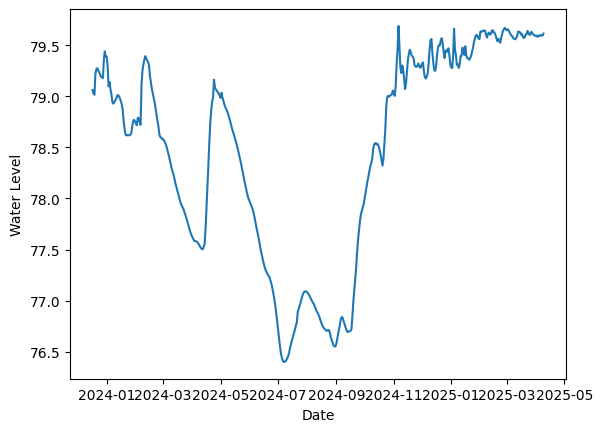

In [26]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Water Level':y_pred_future})
plt = sns.lineplot(data=df_forecast, x='Date', y='Water Level')
df_forecast.set_index('Date', inplace=True)

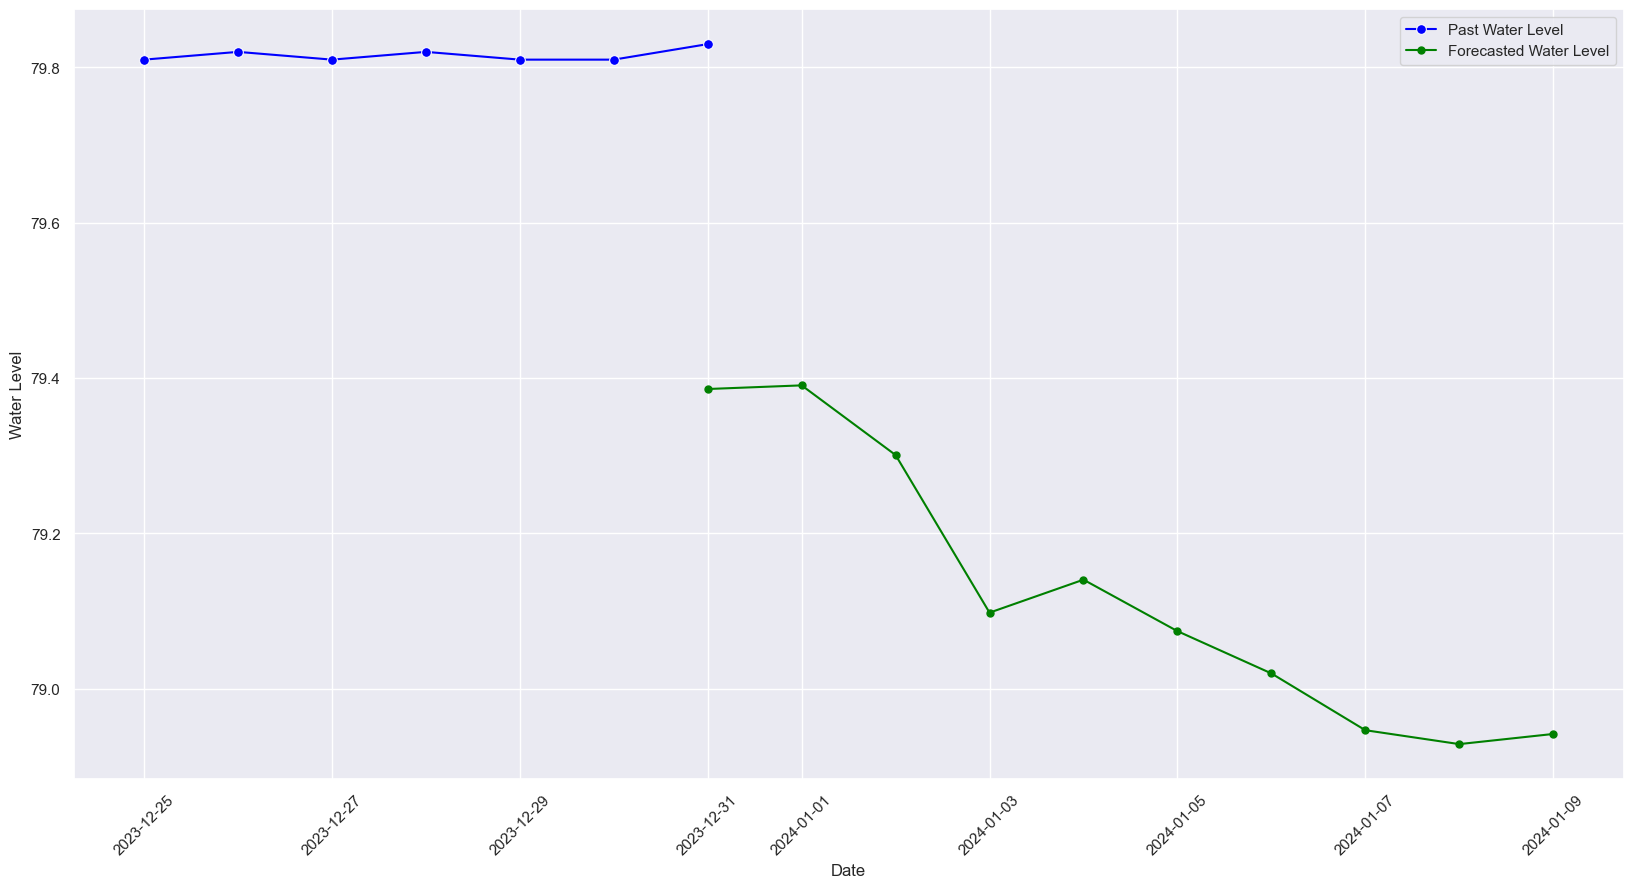

<Figure size 2000x1000 with 0 Axes>

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# For the past data
original = data[['Water Level']]
original = original.loc[(original.index >= original.index[-7]) & (original.index <= original.index[-1])]

# For the forecasted data plot
last_known_date = original.index[-1]
start_date = last_known_date + pd.Timedelta(days=0)
forecast_end_date = start_date + pd.Timedelta(days=9)
forecast_dates = pd.date_range(start=start_date, end=forecast_end_date)
forecast_values = df_forecast.loc[forecast_dates, 'Water Level']

# Connect the past data to the forecasted data
last_known_value = original['Water Level'].iloc[-1]

# Plotting
sns.set(rc={'figure.figsize':(20, 10)})
sns.lineplot(data=original, x=original.index, y='Water Level', color='blue', marker='o', markersize=7, label='Past Water Level')
plt.plot(forecast_dates, forecast_values, label='Forecasted Water Level', color='green', marker='o', markersize=5)

#plt.plot([last_known_date, forecast_dates[0]], [last_known_value, forecast_values.iloc[0]], color='red', linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.savefig('water_level.png', transparent=True)

In [28]:
# sMAPE of actual data to forecasted data
act_smape = np.mean(2.00*(np.abs(df_forecast['Water Level'].iloc[14] - original['Water Level'].iloc[-1]) / (df_forecast['Water Level'].iloc[14] + original['Water Level'].iloc[-1]))) * 100
act_smape 

0.5579327114064634

In [29]:
df_forecast.iloc[14]

Water Level    79.385841
Name: 2023-12-31, dtype: float32

In [30]:
original.iloc[-1]

Water Level    79.83
Name: 2023-12-31 00:00:00, dtype: float64

In [70]:
# Calculate MAPE
mape = np.mean(np.abs((data - df_forecast) / data)) * 100
print(mape)

0.578738623671519


In [42]:
y_true = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 2))), axis=1))
y_pred = scaler.inverse_transform(np.concatenate((model.predict(X_test).reshape(-1, 1), np.zeros((len(y_test), 2))), axis=1))

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print("Mean Absolute Error (MAE):", mae)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Mean Absolute Error (MAE): 0.03154708084704795


In [43]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)
rmse = round(rmse, 2)
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.08


In [44]:
from sklearn.metrics import r2_score

# Calculate R-squared
r_squared = r2_score(y_true, y_pred)
print("R-squared:", r_squared)


R-squared: 0.9936754396964872
